In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

reload()
# !pip install matplotlib-venn

In [2]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    for work in state.related - state.find("s0").related:
        backward |= (set(strategy.ref[work]) & state.related)
        forward |= (set(strategy.rev_ref[work]) & state.related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

### Snowballing - Busca via FS e BS no Artigo mais Citado (Seed Set = 1)

Não realiza busca em DL.
Realiza uma busca, via Forward e/ou via Backward para encontrar artigos do seed set no artigo mais citado, exemplo, mendes2004a.

### Forward

In [3]:
### Delta Related = Conector do nó
strategy = Strategy({work_by_varname("mendes2004a")})
strategy.forward().delta_related

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data}

In [4]:

{x.metakey for x in strategy.backward().visited}


{'briand1999a',
 'briand2000a',
 'christodoulou2000a',
 'cook1977a',
 'jeffery2000a',
 'jeffery2001a',
 'kemerer1987a',
 'kitchenham1984a',
 'kitchenham1998a',
 'kitchenham2001a',
 'kitchenham2004a',
 'maxwell2002a',
 'mendes2003a',
 'mendes2003b',
 'mendes2004a',
 'shepperd2001a',
 'wieczorek2002a',
 'wilcoxon1945a'}

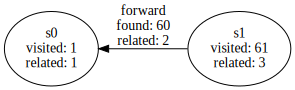

In [5]:
### Grafo
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.forward()

In [6]:
### Related do S1
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.forward().related

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data,
 Further comparison of cross-company and within-company effort estimation models for web applications}

### Backward

In [7]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().delta_related

{A comparison of cross-company and within-company effort estimation models for web applications}

In [8]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().visited

{A comparison of cross-company and within-company effort estimation models for web applications,
 An empirical validation of software cost estimation models,
 A replicated assessment of the use of adaptation rules to improve Web cost estimation,
 Using simulation to evaluate prediction techniques,
 WWW2000: The Developer's view and a practitioner's approach to Web Engineering,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 What accuracy statistics really measure,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Using public domain metrics to estimate software development effort,
 Assessment and comparison of common software cost estimation modeling techniques,
 Applied statistics for software managers,
 Software cost models,
 Individual comparisons by ranking methods,
 How valuable is company-specific data compared to multi-company data for software c

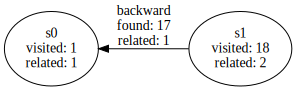

In [9]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward()

In [10]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().name

's1'

### Snowballing - Forward and Backward - Union (N vezes)

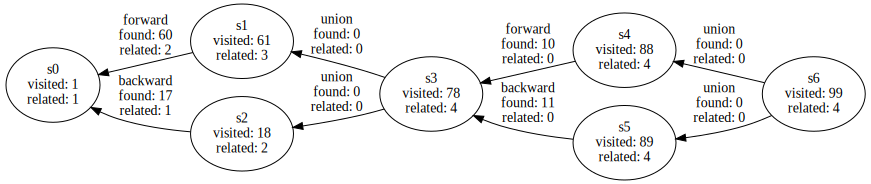

In [11]:
State.last_id = 0
state = strategy.sfbu()
state

In [12]:
len(state.visited - state.find("s0").visited)

98

In [13]:
state.related - state.find("s0").related

{A comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data}

In [14]:
print("Relacionados:")
state.find("s5").delta_visited

Relacionados:


{Case studies for method and tool evaluation,
 Local vs. global models for effort estimation and defect prediction,
 On the relative value of cross-company and within-company data for defect prediction,
 Exploiting the essential assumptions of analogy-based effort estimation,
 Software engineering metrics and models,
 How to find relevant data for effort estimation?,
 The need for web engineering: An introduction,
 A study of project selection and feature weighting for analogy based software cost estimation,
 Comparison of Web size measures for predicting Web design and authoring effort,
 Web cost estimation and productivity benchmarking,
 Statistical power analysis for the behavioral sciences}

In [15]:
print("Relacionados:")
state.find("s5").delta_visited - state.find("s5").delta_visited

Relacionados:


set()

In [16]:
state.find("s4").related

{A comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data,
 Further comparison of cross-company and within-company effort estimation models for web applications}

In [17]:
print("Relacionados:")
state.find("s4").delta_visited

Relacionados:


{Effort estimation of web-based applications using machine learning techniques,
 Sharing data and models in software engineering,
 A comparison of cross-versus single-company effort prediction models for web projects,
 An Empirical Analysis of Three-Stage Data-Preprocessing for Analogy-Based Software Effort Estimation on the ISBSG Data,
 An empirical analysis of data preprocessing for machine learning-based software cost estimation,
 Mining app stores: Extracting technical, business and customer rating information for analysis and prediction,
 La práctica de la estimación en empresas y áreas de Sistemas,
 Empirical Assessment of Machine Learning Models for Effort Estimation of Web-based Applications,
 From Function Points to COSMIC-A Transfer Learning Approach for Effort Estimation,
 Systematic literature review on effort estimation for Open Sources (OSS) web application development}

In [18]:
print("Visitados:")
state.find("s0").visited

Visitados:


{Further comparison of cross-company and within-company effort estimation models for web applications}

In [19]:
#Visualização de Backward
#state.related & set(strategy.ref[work_by_varname("mendes2004a")])

state.find("s0").related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

## Estratégias

### Estratégia 1 - Busca em todas Digital Libraries (DL)

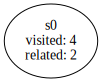

In [20]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy
strategy.initial

#strategy.initial.name

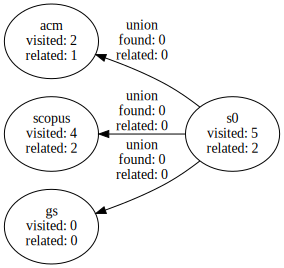

In [21]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["acm", "scopus", "gs"], filter_function)
#strategy.initial.find("acm")
strategy.initial

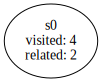

In [22]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited
state

In [23]:
array = []

name = "E1"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E1
0.5
Recall E1
0.5


In [24]:
len ([x for _, x in load_work_map_all_years() if x.category == "snowball"])

4

### Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

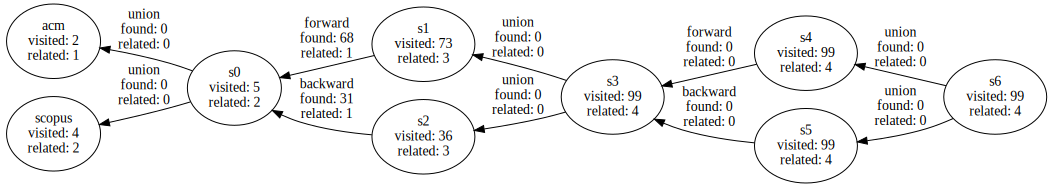

In [39]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

In [40]:
separa_backward_forward(state) @ metakey_title

[['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications'],
 ['premraj2007a - Building software cost estimation models using homogenous data']]

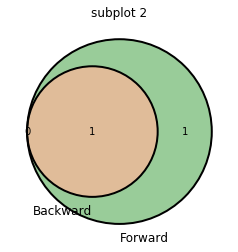

In [41]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('subplot 2')
plt.show()

In [42]:
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['mendes2004a']
Forward ['ferrucci2012a', 'mendes2004a']


In [43]:
x = v.get_patch_by_id('100')

In [44]:
x.set_linestyle = "black"

In [45]:
state.find("s0").related @ metakey

['ferrucci2012a', 'mendes2004a']

In [46]:
[x.metakey for x in state.find("s0").related]

['ferrucci2012a', 'mendes2004a']

In [48]:
diff_related = state.related - state.find("s0").related
diff_related @ metakey_title

['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications',
 'premraj2007a - Building software cost estimation models using homogenous data']

In [34]:
 descreve_delta(strategy, state, "s2")

backward ferrucci2012a
- kitchenham2001a 
- turhan2009a 
- kocaguneli2011a 
- mendes2002a 
- cohen1988a 
- kitchenham2004a related
- menzies2011a 
- kocaguneli2012a 
- li2009a 
- kocaguneli2010a 
- mendes2008a 
- conte1986a 
- kitchenham1998a 
- mendes2003a 
- shepperd2001a 
- kitchenham1995a 
- mendes2007a 
- kitchenham2007a 
- mendes2008b 
- mendes2005a 
- maxwell2002a 
- mendes2005b 
- cook1977a 
backward mendes2004a
- kitchenham2004a related
- kemerer1987a 
- mendes2003b 
- shepperd2001a 
- christodoulou2000a 
- kitchenham2001a 
- briand1999a 
- maxwell2002a 
- kitchenham1984a 
- wilcoxon1945a 
- wieczorek2002a 
- kitchenham1998a 
- mendes2003a 
- cook1977a 
- briand2000a 
forward mendes2004a
- mendes2007a 
- kitchenham2007a 
- mendes2008b 
- mendes2005b 
- kocaguneli2010a 


In [35]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision na Busca E2: 0.40%

Precision no Snowballing E2: 0.02%
Precision no Snowballing E2 - Forward - 1 iteração: 0.01%
Precision no Snowballing E2 - Backward - 1 iteração: 0.03%

Precision E2 (Busca + Snowballing): 0.04%
Precision E2
0.04040404040404041
Recall E2
1.0


### Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

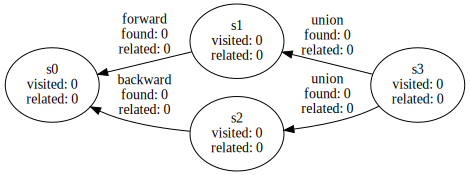

In [36]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [37]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E3


ZeroDivisionError: division by zero

### Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.sfbu()
state

In [ ]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

In [ ]:
state.find("s0").related

In [ ]:
state.find("s2").related

In [ ]:
state.find("s0").visited

In [ ]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

In [ ]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

In [ ]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

In [ ]:
len(state.find("s1").delta_visited)

In [ ]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

In [ ]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

In [ ]:
search_state = strategy.initial
search_state.related

### Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [ ]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

In [ ]:
state.find("s0").related 

In [ ]:
state.find("s1").related 

In [ ]:
state.find("s5").related 

In [ ]:
sx, sy = state.previous[0]

sx.related & sy.related


In [ ]:
sx.name

In [ ]:
sy.name

### Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [ ]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

### Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [ ]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

### Análise das Estratégias

In [ ]:
%matplotlib notebook
import pandas as pd

In [ ]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall'])
df.index = df['Estratégia']
df

In [ ]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


## Antigo

In [ ]:

s5 = state.find("s5")
s5

In [ ]:
s5.delta_related

In [ ]:
state.previous[0][1].previous[0][0].related

In [ ]:
state

In [ ]:
s1 = state.find("s1")
total = sum(1 for _, w in load_work_map_all_years() if w.category == "snowball")

In [ ]:
len(s1.delta_related) / len(s1.delta_visited)

In [ ]:
len(s1.delta_related) / total

In [ ]:
len(state.related) / len(state.visited)

In [ ]:
len(state.related) / total

In [ ]:
state.log

In [ ]:
len(state.visited)

In [ ]:
with open("output/snowballing.provn", "w") as provn:
    provn.write(state.provn)

In [ ]:
!provconvert.bat -infile output/snowballing.provn -outfile output/snowballing.dot

In [ ]:
with open("output/snowballing.dot", "r") as prov_dot:
    text = prov_dot.read().replace('rankdir="BT";', 'rankdir="RL"; ranksep="0.1";')
with open("output/snowballing.dot", "w") as prov_dot:
    prov_dot.write(text)

In [ ]:
!dot -Tpng output/snowballing.dot -ooutput/snowballing.png
!dot -Tsvg output/snowballing.dot -ooutput/snowballing.svg
#!inkscape -D -z --file=output/snowballing.svg --export-pdf=output/snowballing.pdf

In [ ]:
from IPython.display import Image
Image("output/snowballing.png")

In [ ]:
log = state.log

In [ ]:
len([x for _, x in load_work_map_all_years() if x.category in ('snowball','ok','backward')])

In [ ]:
from fractions import Fraction
for step in log:
    print("precision", Fraction(step.new_related, step.new_references))

In [ ]:
len([x for x in state.visited if x.category in {"snowball"}])

In [ ]:
from snowballing.approaches import get_approaches
len(get_approaches())

In [ ]:
visited = state.visited
len([(x, x.year) for x in state.visited
     if x.category in {"nofile"}
     if x.place.name != "Tech Report"
     if x.place.name != "Book"
     if x.place.name != "Patent"
     if x.place.name == "Conference"
     if x.display != x.place.acronym
    ])
#count = 0
#for x in visited:
#     if hasattr(x, 'dglibrary'):
#        print(x.dglibrary)
#        count = 1 + count
#print (count)
len([
    (x, x.year) for x in visited
     if hasattr(x, 'dglibrary') and x.dglibrary=="Scopus"
    
])

def count_ref(library,obj):
    len_dglibrary = len([(x, x.year) for x in obj
                             if hasattr(x, 'dglibrary') and library in x.dglibrary  
                        ])
    len_backward = len([(x, x.year) for x in obj
                             if x.category=="backward"  
                        ])
    len_forward = len([(x, x.year) for x in obj
                             if x.category=="forward"  
                        ])
    qtdref=0
    qtdcitations=0
    for x in obj:
        qtdref=qtdref + int(getattr(x, "references", 0))
        
    scopus = sum(int(getattr(x, "scopus", 0)) for x in obj)
            
    for x in obj:
        qtdcitations=qtdcitations + int(getattr(x, "citations", 0))
    return len_dglibrary,qtdref,qtdcitations,len_backward,len_forward
     

print ("Digital Library, Referencias, Citações, Qtd Backward, Qtd Forward")
print(count_ref("Scopus",visited))

log

print (log[0].name, log[0].new_references)
print(log[1].name, log[1].new_references)
print(log[2].name, log[2].new_references)
print(log[3].name, log[3].new_references)
print("visitados", len(visited))

In [ ]:
len([x for x in visited if x.category in {"lang"}])

In [ ]:
len([x for x in visited if x.category in {"site"}])

In [ ]:
len([x for x in visited
     if x.place.name == "Tech Report"
    ])

In [ ]:
len([x for x in visited
     if x.place.name == "ESEM"
    ])

In [ ]:
{x.category for x in visited}

In [ ]:
[(x.year, x.authors, x.name, x.place.name, x.request) for x in visited
 if x.category in {"nofile"}
 if x.place.name != "Tech Report"
 if x.place.name != "Book"
 if x.place.name != "Patent"
 if x.display != x.place.acronym]

In [ ]:
len(_)